# The Product Pricer Continued

A model that can estimate how much something costs, from its description.

## AT LAST - it's time for Fine Tuning!

After all this data preparation, and old school machine learning, we've finally arrived at the moment you've been waiting for. Fine-tuning a model.

In [1]:
# imports

import os
import re
import math
import json
import random
from dotenv import load_dotenv
from huggingface_hub import login
from items import Item
import matplotlib.pyplot as plt
import numpy as np
import pickle
from collections import Counter
from openai import OpenAI
from anthropic import Anthropic

In [ ]:

from testing import Tester

In [ ]:
# environment

load_dotenv()
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY', 'your-key-if-not-using-env')



In [5]:
openai = OpenAI()

In [6]:
%matplotlib inline

In [7]:
# Let's avoid curating all our data again! Load in the pickle files:

with open('train.pkl', 'rb') as file:
    train = pickle.load(file)

with open('test.pkl', 'rb') as file:
    test = pickle.load(file)

In [ ]:
# OpenAI recommends fine-tuning with populations of 50-100 examples
# But as our examples are very small, we go with 200 examples (and 1 epoch)

fine_tune_train = train[:200]
fine_tune_validation = train[200:250]

# Step 1

Prepare our data for fine-tuning in JSONL (JSON Lines) format and upload to OpenAI

In [ ]:
# First let's work on a good prompt for a Frontier model

def messages_for(item):
    system_message = "You estimate prices of items. Reply only with the price, no explanation"
    user_prompt = item.test_prompt().replace(" to the nearest dollar","").replace("\n\nPrice is $","")
    return [
        {"role": "system", "content": system_message},
        {"role": "user", "content": user_prompt},
        {"role": "assistant", "content": f"Price is ${item.price:.2f}"}
    ]

In [11]:
# Convert the items into a list of json objects - a "jsonl" string
# Each row represents a message in the form:
# {"messages" : [{"role": "system", "content": "You estimate prices...


def make_jsonl(items):
    result = ""
    for item in items:
        messages = messages_for(item)
        messages_str = json.dumps(messages)
        result += '{"messages": ' + messages_str +'}\n'
    return result.strip()

In [12]:
print(make_jsonl(train[:3]))

{"messages": [{"role": "system", "content": "You estimate prices of items. Reply only with the price, no explanation"}, {"role": "user", "content": "How much does this cost?\n\nGerber Danze 9-Inch Adjustable Showerarm with Escutcheon, Tumbled Bronze\nProduct Description Danze 9-inch adjustable showerarm with escutcheon, tumbled bronze. Heavy-duty metal construction for durability and dependability. Allows you to adjust the showerhead for best angle and height. 9-Inch adjustable showerarm. High flow capacity. Tumbled bronze finish. Whether you\u2019re building a new home or simply remodeling, Danze has numerous home d\u00e9cor collections to choose from. Danze is an entrepreneurial company who believes that style and design have the power to transform any d\u00e9cor! Danze products are manufactured using the highest quality materials for precise fit, finish, and dependability. Danze emphasis is on creating products that are an expression of our customers and their relentless search for"

In [13]:
# Convert the items into jsonl and write them to a file

def write_jsonl(items, filename):
    with open(filename, "w") as f:
        jsonl = make_jsonl(items)
        f.write(jsonl)

In [14]:
write_jsonl(fine_tune_train, "fine_tune_train.jsonl")

In [15]:
write_jsonl(fine_tune_validation, "fine_tune_validation.jsonl")

In [16]:
with open("fine_tune_train.jsonl", "rb") as f:
    train_file = openai.files.create(file=f, purpose="fine-tune")

In [17]:
train_file

FileObject(id='file-JxnQrihK5Lj81Dc8EGx5mk', bytes=190371, created_at=1741479112, filename='fine_tune_train.jsonl', object='file', purpose='fine-tune', status='processed', status_details=None, expires_at=None)

In [18]:
with open("fine_tune_validation.jsonl", "rb") as f:
    validation_file = openai.files.create(file=f, purpose="fine-tune")

In [19]:
validation_file

FileObject(id='file-6faJHQjXtYLELGWKag6Lwy', bytes=47015, created_at=1741479125, filename='fine_tune_validation.jsonl', object='file', purpose='fine-tune', status='processed', status_details=None, expires_at=None)

# Step 2


First set up your weights & biases free account at:

https://wandb.ai

From the Avatar >> Settings menu, near the bottom, you can create an API key.

Then visit the OpenAI dashboard at:

https://platform.openai.com/account/organization

In the integrations section, you can add your Weights & Biases key.

## And now time to Fine-tune!

In [20]:
wandb_integration = {"type": "wandb", "wandb": {"project": "gpt-pricer"}}

In [21]:
train_file.id

'file-JxnQrihK5Lj81Dc8EGx5mk'

In [22]:
openai.fine_tuning.jobs.create(
    training_file=train_file.id,
    validation_file=validation_file.id,
    model="gpt-4o-mini-2024-07-18",
    seed=42,
    hyperparameters={"n_epochs": 1},
    suffix="pricer"
)

FineTuningJob(id='ftjob-WoDeFGWnGPYKANiteWC0Rtji', created_at=1741479579, error=Error(code=None, message=None, param=None), fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(batch_size='auto', learning_rate_multiplier='auto', n_epochs=1), model='gpt-4o-mini-2024-07-18', object='fine_tuning.job', organization_id='org-UNQQEr7zksIWze5rnBWueqnw', result_files=[], seed=42, status='validating_files', trained_tokens=None, training_file='file-JxnQrihK5Lj81Dc8EGx5mk', validation_file='file-6faJHQjXtYLELGWKag6Lwy', estimated_finish=None, integrations=[], method=Method(dpo=None, supervised=MethodSupervised(hyperparameters=MethodSupervisedHyperparameters(batch_size='auto', learning_rate_multiplier='auto', n_epochs=1)), type='supervised'), user_provided_suffix='pricer', metadata=None)

In [23]:
openai.fine_tuning.jobs.list(limit=1)

SyncCursorPage[FineTuningJob](data=[FineTuningJob(id='ftjob-WoDeFGWnGPYKANiteWC0Rtji', created_at=1741479579, error=Error(code=None, message=None, param=None), fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(batch_size=1, learning_rate_multiplier=1.8, n_epochs=1), model='gpt-4o-mini-2024-07-18', object='fine_tuning.job', organization_id='org-UNQQEr7zksIWze5rnBWueqnw', result_files=[], seed=42, status='validating_files', trained_tokens=None, training_file='file-JxnQrihK5Lj81Dc8EGx5mk', validation_file='file-6faJHQjXtYLELGWKag6Lwy', estimated_finish=None, integrations=[], method=Method(dpo=None, supervised=MethodSupervised(hyperparameters=MethodSupervisedHyperparameters(batch_size=1, learning_rate_multiplier=1.8, n_epochs=1)), type='supervised'), user_provided_suffix='pricer', metadata=None)], has_more=False, object='list')

In [24]:
job_id = openai.fine_tuning.jobs.list(limit=1).data[0].id

In [25]:
job_id

'ftjob-WoDeFGWnGPYKANiteWC0Rtji'

In [26]:
openai.fine_tuning.jobs.retrieve(job_id)

FineTuningJob(id='ftjob-WoDeFGWnGPYKANiteWC0Rtji', created_at=1741479579, error=Error(code=None, message=None, param=None), fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(batch_size=1, learning_rate_multiplier=1.8, n_epochs=1), model='gpt-4o-mini-2024-07-18', object='fine_tuning.job', organization_id='org-UNQQEr7zksIWze5rnBWueqnw', result_files=[], seed=42, status='validating_files', trained_tokens=None, training_file='file-JxnQrihK5Lj81Dc8EGx5mk', validation_file='file-6faJHQjXtYLELGWKag6Lwy', estimated_finish=None, integrations=[], method=Method(dpo=None, supervised=MethodSupervised(hyperparameters=MethodSupervisedHyperparameters(batch_size=1, learning_rate_multiplier=1.8, n_epochs=1)), type='supervised'), user_provided_suffix='pricer', metadata=None)

In [35]:
openai.fine_tuning.jobs.list_events(fine_tuning_job_id=job_id, limit=10).data

[FineTuningJobEvent(id='ftevent-zeHwBa7ZHsR0fZiemk0TJEec', created_at=1741480225, level='info', message='The job has successfully completed', object='fine_tuning.job.event', data={}, type='message'),
 FineTuningJobEvent(id='ftevent-yqOHRsqxv2BpdESIUIDL2PUD', created_at=1741480220, level='info', message='New fine-tuned model created', object='fine_tuning.job.event', data={}, type='message'),
 FineTuningJobEvent(id='ftevent-qd86BFmmaaVQlVuXF7D5OXjl', created_at=1741480173, level='info', message='Step 200/200: training loss=0.45, validation loss=0.88, full validation loss=1.01', object='fine_tuning.job.event', data={'step': 200, 'train_loss': 0.4470510482788086, 'valid_loss': 0.8792526721954346, 'total_steps': 200, 'full_valid_loss': 1.0104474401474, 'train_mean_token_accuracy': 0.875, 'valid_mean_token_accuracy': 0.875, 'full_valid_mean_token_accuracy': 0.81}, type='metrics'),
 FineTuningJobEvent(id='ftevent-hcgQrxhpRs7rkNWM0byzggXt', created_at=1741480163, level='info', message='Step 19

# Step 3

Test our fine tuned model

In [36]:
fine_tuned_model_name = openai.fine_tuning.jobs.retrieve(job_id).fine_tuned_model

In [37]:
fine_tuned_model_name

'ft:gpt-4o-mini-2024-07-18:personal:pricer:B8yqZAmp'

In [38]:
# The prompt

def messages_for(item):
    system_message = "You estimate prices of items. Reply only with the price, no explanation"
    user_prompt = item.test_prompt().replace(" to the nearest dollar","").replace("\n\nPrice is $","")
    return [
        {"role": "system", "content": system_message},
        {"role": "user", "content": user_prompt},
        {"role": "assistant", "content": "Price is $"}
    ]

In [40]:
# A utility function to extract the price from a string

def get_price(s):
    s = s.replace('$','').replace(',','')
    match = re.search(r"[-+]?\d*\.\d+|\d+", s)
    return float(match.group()) if match else 0

In [42]:
# The function for gpt-4o-mini

def gpt_fine_tuned(item):
    response = openai.chat.completions.create(
        model=fine_tuned_model_name, 
        messages=messages_for(item),
        seed=42,
        max_tokens=7
    )
    reply = response.choices[0].message.content
    return get_price(reply)

1: Guess: $199.00 Truth: $195.99 Error: $3.01 SLE: 0.00 Item: Vertex Ultraphonix MKII Overdrive
2: Guess: $29.99 Truth: $38.99 Error: $9.00 SLE: 0.07 Item: Wood Grip | Universal Conversion Kit | B...
3: Guess: $32.00 Truth: $1.00 Error: $31.00 SLE: 7.86 Item: Traxxas 1726 Antenna, Tube, Vinyl Antenn...
4: Guess: $349.99 Truth: $299.99 Error: $50.00 SLE: 0.02 Item: Jackson JS Series Dinky Arch Top JS32Q D...
5: Guess: $262.47 Truth: $374.99 Error: $112.52 SLE: 0.13 Item: TOTO LPT754.8#01 Whitney Lavatory and Pe...
6: Guess: $10.49 Truth: $64.95 Error: $54.46 SLE: 3.05 Item: Sliding Glass Patio Door Handle Set, Mor...
7: Guess: $322.22 Truth: $279.99 Error: $42.23 SLE: 0.02 Item: First Watch / Homak 6-Gun Security Cabin...
8: Guess: $154.65 Truth: $131.85 Error: $22.80 SLE: 0.03 Item: WEN 3921 16-inch Two-Direction Variable ...
9: Guess: $139.98 Truth: $185.11 Error: $45.13 SLE: 0.08 Item: Tropwellhouse Crytal Ceiling Fan with Li...
10: Guess: $69.99 Truth: $72.69 Error: $2.70 SLE: 0.00 

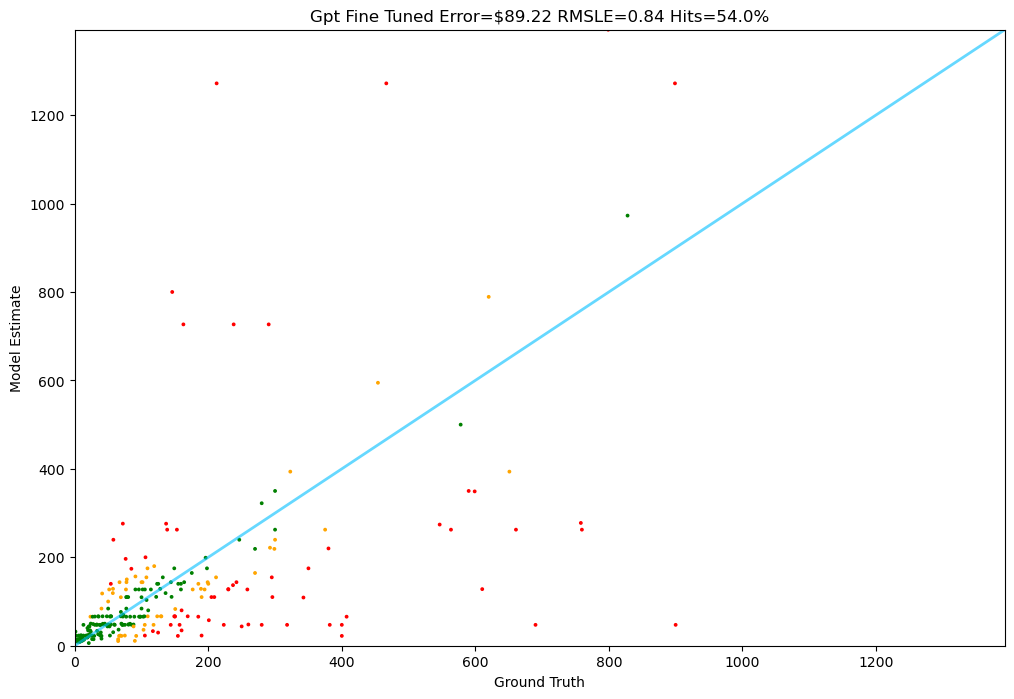

In [45]:
Tester.test(gpt_fine_tuned, test)